# Ex 2: Manipulating Spectra Part 2 - `Spectra`

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as physics
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra

## `Spectra` Class - Introduction

The `Spectra` class is simply a collection of `Spectrum` objects. The main use of `Spectra` is as a list of spectra produced by the same process at different redshifts. It is the parent class of `TransFuncAtEnergy` and `TransFuncAtRedshift`, which are useful classes for transfer functions described in a later example. 

To demonstrate how to use this class, consider the extragalactic photon flux coming from the smooth distribution of dark matter throughout the universe, decaying with some spectrum $dN/dE(z)$. This is given by (see Essig et al. 1309.4091): 

$$ \frac{d^2 \Phi}{d\Omega \, dE} = \frac{1}{4\pi} \frac{\Gamma \Omega_{\text{DM}} \rho_c}{m_{\text{DM}} H_0 \sqrt{\Omega_m}} \int_0^\infty dz \frac{dN}{dE(z)} \frac{1}{(1 + z)^{3/2}} \frac{1}{\sqrt{1 + \kappa(1 + z)^{-3}}} $$

where $\kappa = \Omega_\Lambda/\Omega_m$, and $\Gamma$ is the decay width. $dN/dE(z)$ is the photon spectrum observed today from a decay event at redshift $z$, with $E(z) = E(1+z)$. 

With a delta function photon spectrum from the decay, $dN/dE(z) = \delta(E(z) - m_{\text{DM}}/2)$, the photon flux can be evaluated exactly as

$$ \frac{d^2 \Phi}{d\Omega \, dE} = \frac{1}{4\pi} \frac{\Gamma \Omega_{\text{DM}} \rho_c}{m_{\text{DM}} H_0 \sqrt{\Omega_m}} \cdot \frac{2}{m_{\text{DM}}} \sqrt{\frac{2E}{m_{\text{DM}}}} \frac{\Theta(E - m_{\text{DM}}/2)}{\sqrt{1 + \kappa(2E/m_{\text{DM}})^3}} $$

Instead of evaluating this analytically, we will now instead compute a discrete approximation of the first equation, and see that we recover some approximation of the final analytic result. 

To begin, we will initialize a list of `Spectrum` objects, each containing a delta function at half the dark matter mass, taken to be $m_{\text{DM}}$ = 1 GeV. This can be efficiently done by `spectools.rebin_N_arr`, which takes a list of energies, a list containing the number of particles at that energy, and an output energy abscissa, and returns a `Spectrum` object with the output energy abscissa and `Spectrum.dNdE` approximating the initial particle input, conserving both total number and total energy. 

The number of particles must be carefully initialized. Note that

$$ N = \int dE \frac{dN}{dE(z)} = \int dE \, \delta \left( E(1+z) - \frac{m_{\text{DM}}}{2} \right) = \frac{1}{1+z} $$

In [3]:
mDM = 1

# Energy and redshift abscissa.
# Redshift is ordered from largest to smallest. 
eng = 10**np.arange(-3, 0, 0.05)
rs_arr  = 10**np.arange(3, 0, -0.003)


# Create the list of Spectrum objects. 
spec_arr = [
    spectools.rebin_N_arr(np.array([1/rs]), np.array([mDM/2]), eng)
    for rs in rs_arr
           ]

# Assign the correct redshift to each of the Spectrum objects. 
# The first Spectrum object is assigned the largest redshift.
for spec,rs in zip(spec_arr,rs_arr):
    spec.rs = rs

We are now ready to use the `Spectra` class. Given a list of `Spectrum` objects with identical energy abscissa, *ordered in decreasing redshift*, we can create a `Spectra` object as follows:

In [4]:
photon_flux = Spectra(spec_arr)

If the `Spectrum` objects have different abscissa, the keyword argument `rebin_eng` can be used to rebin all of them into the same abscissa.

A few simple functions exist to get attributes from the `Spectrum` objects stored in a `Spectra` object:

In [5]:
print('The energy abscissa of each Spectrum in photon_flux is: ')
print(photon_flux.get_eng())
print('*****************************************************************')
print('The redshift of each Spectrum in photon_flux is: ')
print(photon_flux.get_rs())
print('*****************************************************************')
print('The injection energy of each Spectrum in photon_flux is: ')
print(photon_flux.get_in_eng())
print('*****************************************************************')

The energy abscissa of each Spectrum in photon_flux is: 
[ 0.001       0.00112202  0.00125893  0.00141254  0.00158489  0.00177828
  0.00199526  0.00223872  0.00251189  0.00281838  0.00316228  0.00354813
  0.00398107  0.00446684  0.00501187  0.00562341  0.00630957  0.00707946
  0.00794328  0.00891251  0.01        0.01122018  0.01258925  0.01412538
  0.01584893  0.01778279  0.01995262  0.02238721  0.02511886  0.02818383
  0.03162278  0.03548134  0.03981072  0.04466836  0.05011872  0.05623413
  0.06309573  0.07079458  0.07943282  0.08912509  0.1         0.11220185
  0.12589254  0.14125375  0.15848932  0.17782794  0.19952623  0.22387211
  0.25118864  0.28183829  0.31622777  0.35481339  0.39810717  0.44668359
  0.50118723  0.56234133  0.63095734  0.70794578  0.79432823  0.89125094]
*****************************************************************
The redshift of each Spectrum in photon_flux is: 
[ 1000.           993.11604842   986.27948563   979.48998541   972.74722378
   966.05087899   95

Another useful function is `Spectra.get_grid_values()`, which returns a 2D array of `Spectrum.dNdE` values, indexed by (redshift, energy).

## Basic Operations

The integral in the first equation now needs to be approximated by a sum of discrete spectra:

$$\int_0^\infty dz \frac{dN}{dE(z)} \frac{1}{(1 + z)^{3/2}} \frac{1}{\sqrt{1 + \kappa(1 + z)^{-3}}} \\
\approx \sum_i (1+z_i) \Delta \log (1+z_i) \frac{dN}{dE(1+z_i)} \frac{1}{(1 + z_i)^{3/2}} \frac{1}{\sqrt{1 + \kappa(1 + z_i)^{-3}}}$$

To find $\Delta \log z_i$, we use the convenience function `spectools.get_log_bin_width`: 

In [6]:
dlogz = -spectools.get_log_bin_width(photon_flux.get_rs())

The negative sign is used to make sure that `dlogz` are all positive (it is returned negative because the redshifts are ordered in decreasing order). 

At this stage, the spectra stored in `photon_flux` are identical delta functions, containing one particle at energy $m_{\text{DM}}/2$. However, $\frac{dN}{dE(1+z_i)}$ is the spectrum as observed today, and must be redshifted to the present day. To do this, we again use `Spectrum.redshift`: 

In [7]:
for spec in photon_flux:
    spec.redshift(1)

Next, each of these spectra must be multiplied by a factor of

$$ \frac{(1+z_i) \Delta \log(1+z_i)}{(1+z_i)^{3/2} \sqrt{1 + \kappa(1 + z_i)^{-3}}} $$

As in the `Spectrum` class, basic mathematical operations with the `Spectra` class go through as expected. We can simply compute an array of this factor, and then muliply `photon_flux` by it:

In [8]:
kappa = physics.omega_lambda/physics.omega_m

fac = rs_arr*dlogz/(rs_arr**(3/2)*np.sqrt(1 + kappa*rs_arr**(-3)))

photon_flux *= fac

We can also multiply in the remaining prefactors (here we choose $\Gamma$ to be in natural units):

In [9]:
# This choice if the width (in GeV) is roughly a lifetime of 1e25 seconds.
Gamma = 1e-50

prefac = (
    (1/(4*np.pi)) * Gamma * physics.omega_DM * physics.rho_crit*1e-9
    / (mDM * physics.H0 * np.sqrt(physics.omega_m))
    )*physics.c/(physics.hbar*1e-9)

photon_flux *= prefac

Note that all units of fundamental parameters in `physics` are given in eV (mass and energy), cm and seconds, and the final value of the photon flux has been multiplied by appropriate numerical factors to give `photon_flux` units of $\text{cm}^{-2} \text{ GeV}^{-1} \text{ s}^{-1}$. 

## Summing of Spectra in `Spectra`

The last remaining thing to do is to perform the integral by summing up the discrete spectra. This can be done using `Spectra.sum_specs`, which returns a `Spectrum` object: 

In [10]:
obs_photon_flux = photon_flux.sum_specs()

Now to compare this with the analytic expression.

In [23]:
def analytic_flux(eng):
    factor = 2/mDM*np.sqrt(2*eng/mDM)*1/np.sqrt(1 + kappa*(2*eng/mDM)**3)
    factor[eng > mDM/2] = 0
    return np.array(prefac*factor)

[0.001, 1, 1e-07, 0.0001]

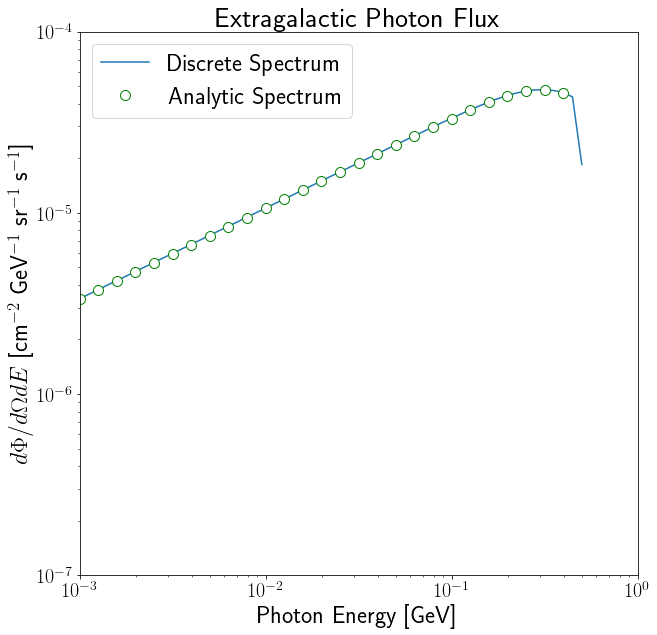

In [31]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

discrete_spec, = plt.plot(
    obs_photon_flux.eng, obs_photon_flux.dNdE, label='Discrete Spectrum'
)

dNdE_analytic = analytic_flux(obs_photon_flux.eng)

analytic_spec, = plt.plot(
    obs_photon_flux.eng, dNdE_analytic, 'go', marker='o', markersize='10', 
    markerfacecolor='w', markevery=2,
    label='Analytic Spectrum'
)

plt.legend(handles=[discrete_spec, analytic_spec], 
           fontsize=24)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Extragalactic Photon Flux', fontsize=28)
plt.xlabel('Photon Energy [GeV]',fontsize=24)
plt.ylabel('$d\Phi/d\Omega dE$ [cm$^{-2}$ GeV$^{-1}$ sr$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-3, 1, 1e-7, 1e-4])

, given approximately by (see Essig et al. 1309.4091):

$$ \frac{dN_{\phi \to e^+ e^- \gamma}}{dE} \simeq \frac{2\alpha_{\text{EM}}}{\pi E_\gamma} \left[1 - \frac{2E_\gamma}{m_\phi} + \left(1 - \frac{2E_\gamma}{m_\phi} + \frac{2E_\gamma^2}{m_\phi^2} \right) \log \left( \frac{1 - 2E_\gamma/m_\phi}{m_e^2/m_\phi^2} \right) \right] $$

with $0 < E_\gamma < m_\phi/2$. This spectrum is per decay. For simplicity, we consider this process during the cosmic dark ages, where the dark matter density was uniform, and that the branching ratio into this process is 100%. We will also not concern ourselves with the overall normalization of this spectrum. 

We will again use `spec.spectools.discretize` to create `Spectrum` objects from this analytic spectrum, taking $m_\phi = $ 2 TeV. First, let's produce one spectrum and check it against the analytic expression. We will use a highly non-uniform binning to capture the threshold behavior near $E_\gamma = m_\phi/2$.

In [12]:
def phi_decay_FSR(eng):
    m_phi = 2000
    m_e = 0.511e-3
    r = eng/m_phi
    r_e = m_e/m_phi
    if eng < m_phi/2:
        return (
            (2/137)/(np.pi*eng)*(1 - 2*r + (1 - 2*r + 2*r**2))
            *np.log((1 - 2*r)/r_e**2)
        )
    else: 
        return 0

eng = 1000-10**np.arange(-7,3,0.005)
eng = eng[::-1]
discrete_FSR = spectools.discretize(phi_decay_FSR, eng)

AttributeError: 'function' object has no attribute 'size'

To create a `Spectra` object, we first create a list of `Spectrum` objects before calling the constructor. Here, we pass a list containing a single element at $1+z = 1000$, and then append `Spectrum` objects to the `Spectra` using `self.append`. We will append the same spectrum to it repeatedly, but with different redshifts `rs` and normalized by `1000/rs**3` so that we are now storing $dN/(dE \, dV)$: DM decays are diluted by a factor of `rs**3` as the universe expands.

In [ ]:
spec_to_append = spectools.discretize(phi_decay_FSR, eng)
spec_to_append.rs = 1000
spectra_FSR = Spectra([spec_to_append])

for rs in 1000/(2+np.arange(9)):
    spec_to_append = spectools.discretize(phi_decay_FSR, eng)/(1000**3/rs**3)
    spec_to_append.rs = rs
    spectra_FSR.append(spec_to_append)

## `Spectra` - Attributes and Operations

The `Spectra` attributes are similar to `Spectrum`. `self.eng` and `self.rs` give the energy and redshift abscissa respectively. Note that all of the `Spectrum` objects must share the same energy abscissa to be stored in the same `Spectra` object. Use `Spectrum.rebin` to rebin `Spectrum` objects into the same abscissa where necessary. 

To get a 2D array of the raw values, indexed by `(eng, rs)`, use `self.grid_values`. 

As with `Spectrum`, we can add two `Spectra` objects, add a scalar to a `Spectra`, and likewise multiply two `Spectra` or multiply by a scalar. 

To access individual `Spectrum` objects, it is possible to get them by specifying an index, as if the `Spectra` object were a list. 

## `Spectra` - Plotting

`Spectra` objects are easy to plot using `self.plot`. They can be plotted at any arbitrary redshift, with the result obtained by interpolation over log of the redshift. Plotting arguments can be passed as keyword arguments. Individual `Spectrum` objects can also be plotted in a number of ways using the keyword `ind` and `indtype`. See documentation for more details.

In [ ]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

rs_to_plot = np.array([900, 450, 225])
spectra_plot = spectra_FSR.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)

plt.legend(spectra_plot, ('1+z = 900','1+z = 450', '1+z = 225'), 
           fontsize=24)


ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('FSR Spectrum', fontsize=28)
plt.xlabel('Photon Energy [GeV]',fontsize=24)
plt.ylabel('dN/(dE dV) [GeV$^{-1}$ cm$^{-3}$]',fontsize=24)
plt.axis([1e2, 2e3, 1e-7, 1e-2])

## `Spectra` - Integration over each Spectrum

Integration over each spectrum can be done using `self.integrate_each_spec`, with the result being an `ndarray`. There are many reasons to perform an integration over each spectrum; here, we will show only a trivial example, integrating over the spectrum to get the total number. To do this, we use `self.integrate_each_spec` with a weight given by $E \, d \log E$. 

In [ ]:
log_bin_width = spectools.get_log_bin_width(spectra_FSR.get_eng())
print('Total number of particles in each spectrum by integrate_each_spec: ')
print(spectra_FSR.integrate_each_spec(spectra_FSR.get_eng() * log_bin_width))
print('Total number of particles in each spectrum by Spectrum.totN(): ')
print(np.array([spec.totN() for spec in spectra_FSR]))

## `Spectra` - Summing Spectra

It is frequently useful to add the spectra in a `Spectra` object up in some way. Here, we want to determine the spectrum of photons that would be observed from $\phi \to e^+e^-\gamma$ through FSR at the last redshift stored in `spectra_FSR`. The DM decays at each redshift, producing a $dN/(dE \, dV)$ stored in `spectra_FSR`. This spectrum is given *per decay*; the total spectrum needs to be re-weighted by the number of decays that occur within a redshift bin. Ignoring overall normalization once again, this means reweighting by a factor of

$$ \Delta t = \frac{dt}{d(1+z)} (1+z) \times \Delta \log (1+z)$$

In [ ]:
rs_array = spectra_FSR.get_rs()
rs_log_bin_width = np.abs(spectools.get_log_bin_width(rs_array))
weight = physics.dtdz(rs_array)*rs_array*rs_log_bin_width
weight /= weight[-1]

To obtain the spectrum that would be observed at the last redshift, the spectrum at each redshift must first be redshifted down to the last redshift. Then, the spectra in `spectra_FSR` are added up, weighted by `weight`, to obtain the (un-normalized) photon spectrum that we would observe. 

In [ ]:
for spec in spectra_FSR.spec_arr:
    spec.redshift(spectra_FSR.get_rs()[-1]) 

In [ ]:
spectra_FSR.get_rs()

In [ ]:
obs_spec = spectra_FSR.sum_specs(weight)

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

spectra_plot, = plt.plot(spectra_FSR.get_eng(), obs_spec, linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Spectrum at $1+z = 100$', fontsize=28)
plt.xlabel('Photon Energy [GeV]',fontsize=24)
plt.ylabel('dN/(dE dV) [GeV$^{-1}$ cm$^{-3}$]',fontsize=24)
plt.axis([3e1, 2e3, 1e-6, 1e-2])